In [1]:
import sympy as sym
import sympy.physics.mechanics as me
from sympy.abc import t as time
import pandas as pd
import seaborn as sns

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import fsolve,least_squares,root

import sys, os
import pickle

sys.path.insert(1, os.path.join(sys.path[0], '../..'))
import custom_plot_objects as cpo

import ModelFramework as mf
import ModelFramework.Elements as ele
import ModelFramework.ExternalForces as ef
import FwtModels.RectWing as rw
import FwtModels.RollRig as RollRig
import multiprocessing as mp
from multiprocessing import set_start_method
#set_start_method("spawn")

from matplotlib.lines import Line2D

me.mechanics_printing()

In [2]:
# Create simplified model
fwt_panels = 10
main_panels = 20

p = RollRig.base_params(Dofs=1, panels = fwt_panels*2 + main_panels)  
sm = mf.SymbolicModel.from_file('RollRigModel-Fixed.py')

In [3]:
sm.ExtForces = ef.CompositeForce([sm.ExtForces,ef.CustomForce(None)])
sm = sm.subs({p.alpha_r.name:0,p.alpha_1.name:0,
             p.alpha_2.name:0})
p.fp = [0,0]
sm_lin = sm.linearise(p)
sm.to_file('tempModel_fixed.py')

In [4]:
# Add fixed params to dict
params = {}
params['c'] = 0.067
params['s'] = 1
params['g'] = 9.81
params['sigma'] = 0.272
params['alpha_r'] = 0
params['c_d_max'] = 1
params['m_w'] = 0.759
params['I_xx_w'] = 0.019480411
params['y_w'] = 0
params['z_w'] = 0
params['c_d_max'] = 0
params['T'] = 0.01

In [5]:
# create lift distribution
def create_lift_dist_from_file(filename,span,sigma,main_panels,fwt_panels):
    s_w = span*(1-sigma)
    delta = s_w / main_panels
    y_panel_main = np.linspace(-s_w/2+delta/2,s_w/2-delta/2,main_panels)

    s_f = span*sigma/2
    delta = s_f / fwt_panels
    y_panel_fwt = np.linspace(delta/2,s_f-delta/2,fwt_panels)+s_w/2
    y_panel = [*-np.flip(y_panel_fwt),*y_panel_main,*y_panel_fwt]

    ## load lift distribution
    df = pd.read_csv(filename)
    y_span = df['y'].to_numpy()
    y_c_l = df['C_l'].to_numpy()

    # interpolate on each panel
    return list(np.interp(np.abs(y_panel),y_span,y_c_l,left=0,right=0))

def create_const_lift_dist(main_panels,fwt_panels):
    return [np.pi*2]*(main_panels+(2*fwt_panels))

def create_tapered_lift_dist(main_panels,fwt_panels):
    val = 2*np.pi
    main_a = [val]*main_panels
    fwt_a = [((i+0.5)/fwt_panels)*val for i in range(fwt_panels)]
    return [*fwt_a,*main_a,*reversed(fwt_a)]

In [6]:
# Calculate Lift Distributions
lift_dists=[]
tmp_params = {}
tmp_params['p'] = 1
tmp_params['a'] = create_const_lift_dist(main_panels,fwt_panels)
# tmp_params['a'] = create_lift_dist_from_file(r'LiftDistribution_aoa_0_rr_60_span_100.csv',params['s'],params['sigma'],main_panels,fwt_panels)
lift_dists.append(({'LiftDist':'Roll60'},tmp_params.copy()))

In [7]:
# create configs
configs = []
tmp_params = {}
tmp_params['Lambda'] = np.deg2rad(10)
tmp_params['alpha_c'] = np.deg2rad(0)
tmp_params['l_f'] = 0.0766*np.cos(tmp_params['Lambda'])
tmp_params['I_xx_f'] = 8.85e-5
tmp_params['m_f'] = 0.0625
configs.append(({'Mode':'Fixed'},tmp_params.copy()))

In [8]:
# create Jobs
attitudes=[]
vs = [30]
for v in vs:
    aas = [7,14,21]
#     for i,tm in enumerate([0]*3):
    for i,tm in enumerate([-1]):
        beta = (tm)*8.4e-4*v**2
        attitudes.append(({"AileronAngle":aas[i],},{"V":v,"beta":beta}))
#     attitudes.append(({"AileronAngle":7,},{"V":v,"beta":(1.05)*8.4e-4*v**2-0.08}))

In [9]:
jobs=[({**config,**att,**lift_dist},{**params,**config_params,**att_params,**lift_dist_params}) for config,config_params in configs for att,att_params in attitudes for lift_dist,lift_dist_params in lift_dists]
#jobs[10]

In [10]:
%%time
j_i = 0
job = jobs[j_i]
ic = [0,0]
names = ['Roll','Roll Rate','Right FWT Angle','Right FWT Velocity','Left FWT Angle','Left FWT Velocity']

def stop_event(t,y):
    return np.deg2rad(360*4+5) - abs(y[0])
stop_event.terminal = True

data = RollRig.GenRunData_StepTorque('tempModel_fixed.py',1,ic,60,params=job[1],
                                     panels=main_panels + 2*fwt_panels,
                                     calc_coast=False,
                                     xNames=names,
                                     additional_cols={**job[0]},
                                     sample_freq=100,
                                     events = [stop_event])

CPU times: user 267 ms, sys: 4.77 ms, total: 272 ms
Wall time: 272 ms


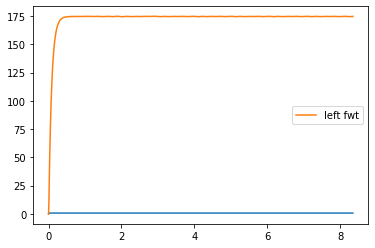

In [11]:
df = pd.DataFrame(data)
# df = df[df['Roll']>=np.deg2rad(720-180)]
# df = df[df['Roll']<np.deg2rad(360*3-180)]
plt.plot(df['t'],df['torque'])
# plt.plot(df['t'],np.rad2deg(df['Roll Rate']),label = 'rr')
plt.plot(df['t'],np.rad2deg(df['Roll Rate']),label = 'left fwt')
# plt.plot(df['t'],np.rad2deg(df['Right FWT Angle']),label = 'right fwt')
# plt.plot(df['t'],np.rad2deg(df['Roll Rate']),label = 'roll')
# plt.plot(np.rad2deg(df['Roll']),(df['lift_mom']),label ='lift')
# plt.plot(np.rad2deg(df['Roll']),(df['centri_mom']),label = 'centri')
# plt.plot(np.rad2deg(df['Roll']),(df['grav_mom']),label = 'grav')
# plt.plot(np.rad2deg(df['Roll']),(df['right_lift']),label = 'rl')
# plt.plot(np.rad2deg(df['Roll']),(df['left_lift']),label = 'll')
# plt.plot(np.rad2deg(df['Roll']),(df['left_lift']+df['right_lift']),label = 'delta')

plt.legend()

In [12]:
df

,t,torque,Roll,Roll Rate,c,s,g,sigma,alpha_r,c_d_max,...,l_f,I_xx_f,m_f,V,beta,p,a,Mode,AileronAngle,LiftDist
0,0.00,0.000,0.000000,0.000000,0.067,1,9.81,0.272,0,0,...,0.075436,0.000088,0.0625,30,-0.756,1,"[6.283185307179586, 6.283185307179586, 6.28318...",Fixed,7,Roll60
1,0.01,0.756,0.000627,0.183899,0.067,1,9.81,0.272,0,0,...,0.075436,0.000088,0.0625,30,-0.756,1,"[6.283185307179586, 6.283185307179586, 6.28318...",Fixed,7,Roll60
2,0.02,0.756,0.004170,0.523835,0.067,1,9.81,0.272,0,0,...,0.075436,0.000088,0.0625,30,-0.756,1,"[6.283185307179586, 6.283185307179586, 6.28318...",Fixed,7,Roll60
3,0.03,0.756,0.010953,0.825376,0.067,1,9.81,0.272,0,0,...,0.075436,0.000088,0.0625,30,-0.756,1,"[6.283185307179586, 6.283185307179586, 6.28318...",Fixed,7,Roll60
4,0.04,0.756,0.020563,1.091067,0.067,1,9.81,0.272,0,0,...,0.075436,0.000088,0.0625,30,-0.756,1,"[6.283185307179586, 6.283185307179586, 6.28318...",Fixed,7,Roll60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
831,8.31,0.756,25.068120,3.046479,0.067,1,9.81,0.272,0,0,...,0.075436,0.000088,0.0625,30,-0.756,1,"[6.283185307179586, 6.283185307179586, 6.28318...",Fixed,7,Roll60
832,8.32,0.756,25.098550,3.047028,0.067,1,9.81,0.272,0,0,...,0.075436,0.000088,0.0625,30,-0.756,1,"[6.283185307179586, 6.283185307179586, 6.28318...",Fixed,7,Roll60
833,8.33,0.756,25.128985,3.047510,0.067,1,9.81,0.272,0,0,...,0.075436,0.000088,0.0625,30,-0.756,1,"[6.283185307179586, 6.283185307179586, 6.28318...",Fixed,7,Roll60
834,8.34,0.756,25.159427,3.047907,0.067,1,9.81,0.272,0,0,...,0.075436,0.000088,0.0625,30,-0.756,1,"[6.283185307179586, 6.283185307179586, 6.28318...",Fixed,7,Roll60


In [13]:
filename = 'tempModel_free.py'
qs = 3
ic = ic
end_time = 60 
params = job[1]
panels = main_panels + 2*fwt_panels
calc_coast=True
xNames=names
additional_cols={**job[0]}
sample_freq=100
events = [stop_event]

def stop_event(t,y):
    return np.deg2rad(360*4+5) - abs(y[0])
stop_event.terminal = True

# Set the parameters
p = RollRig.base_params(qs,panels=panels)
p_vars = vars(p)
for string, value in params.items():
    if string in p_vars:
        p_vars[string].value = value
# Load the Model 
sm = mf.SymbolicModel.from_file(filename)
sm.ExtForces = ef.CompositeForce([sm.ExtForces, ef.CustomForce(None)])

# Create Numeric Model
nm = mf.NumericModel.from_SymbolicModel(p, sm)
ext_f = nm.ExtForces.force_funcs[0]

# coast angle
def objective_func(x, ic):
    y=[0]*6
    y[0] = ic[0]
    y[1] = ic[1]
    y[2] = x[0]
    y[4] = x[1]
    tup = p.GetNumericTuple(y, 0)  
    forces = -nm.f_func(tup,y)+nm.ExtForces(tup,y,0)
    return forces[1][0]**2 + forces[2][0]**2

In [14]:
%%time
# for each job edit the parameters and pool it 
pool = mp.Pool(mp.cpu_count())
names = ['Roll','Roll Rate','Right FWT Angle','Right FWT Velocity','Left FWT Angle','Left FWT Velocity']

res=[]
for job in jobs:
    res.append(pool.apply_async(RollRig.GenRunData_StepTorque, args = ('tempModel_free.py',3,[0]*6,15,job[1],
                                                                       main_panels + 2*fwt_panels,True,
                                                                       names,job[0],500)))
pool.close()
pool.join()

ls = []
for i in res:
    ls += i.get()
df = pd.DataFrame(ls)
df.to_pickle('FixedData.pkl')

CPU times: user 100 ms, sys: 50.1 ms, total: 150 ms
Wall time: 2.17 s


In [15]:
df.to_csv(r'/Users/fintan/Git/FlexiFWT_DAQ/Analysis/RollingRigV3/ModelComparisonV2/FixedData.csv', index = False)

In [16]:
len(jobs)

In [17]:
jobs

[({'Mode': 'Fixed', 'AileronAngle': 7, 'LiftDist': 'Roll60'},
  {'c': 0.067,
   's': 1,
   'g': 9.81,
   'sigma': 0.272,
   'alpha_r': 0,
   'c_d_max': 0,
   'm_w': 0.759,
   'I_xx_w': 0.019480411,
   'y_w': 0,
   'z_w': 0,
   'T': 0.01,
   'Lambda': 0.17453292519943295,
   'alpha_c': 0.0,
   'l_f': 0.07543627388073514,
   'I_xx_f': 8.85e-05,
   'm_f': 0.0625,
   'V': 30,
   'beta': -0.756,
   'p': 1,
   'a': [6.283185307179586,
    6.283185307179586,
    6.283185307179586,
    6.283185307179586,
    6.283185307179586,
    6.283185307179586,
    6.283185307179586,
    6.283185307179586,
    6.283185307179586,
    6.283185307179586,
    6.283185307179586,
    6.283185307179586,
    6.283185307179586,
    6.283185307179586,
    6.283185307179586,
    6.283185307179586,
    6.283185307179586,
    6.283185307179586,
    6.283185307179586,
    6.283185307179586,
    6.283185307179586,
    6.283185307179586,
    6.283185307179586,
    6.283185307179586,
    6.283185307179586,
    6.283185307